In [1]:
import json
import requests
import pandas as pd
import numpy as np
from tqdm import tqdm
import datetime

This is a very simplified example of how Net Options Pricing effect can be derrived from deribit 24hr 
options chain data and using 24hr binance trading pair volum data to express NOPE.
Please note that this model is just an example and to get actual NOPE value for a cryptocurrency pair one would
have to interact with all of the major exchanges to get an absolute and interpretable NOPE.

In [2]:
def get_option_name_and_settlement(coin):
    """
    :param coin: crypto-currency coin name ('BTC', 'ETH')
    :return: 2 lists:
                        1.  list of traded options for the selected coin;
                        2.  list of settlement period for the selected coin.
    """

    r = requests.get("https://test.deribit.com/api/v2/public/get_instruments?currency=" + coin + "&kind=option")
    result = json.loads(r.text)

    #option name
    name = pd.json_normalize(result['result'])['instrument_name']
    name = list(name)

    #option settlement period
    settlement_period = pd.json_normalize(result['result'])['settlement_period']
    settlement_period = list(settlement_period)

    return name, settlement_period


def get_option_data(coin):
    """
    :param coin: crypto-currency coin name ('BTC', 'ETH')
    :return: pandas data frame with all option data for a given coin
    """

    #option name and settlement
    coin_name = get_option_name_and_settlement(coin)[0]
    settlement_period = get_option_name_and_settlement(coin)[1]

    #data frame
    coin_df = []

    #progress bar
    pbar = tqdm(total=len(coin_name))

    #loop to download data for each option name
    for i in range(len(coin_name)):
        #download option data -- requests and convert json to pandas
        r = requests.get('https://test.deribit.com/api/v2/public/get_order_book?instrument_name=' + coin_name[i])
        result = json.loads(r.text)
        df = pd.json_normalize(result['result'])

        #settlement period
        df['settlement_period'] = settlement_period[i]

        #append data to data frame
        coin_df.append(df)

        #update progress bar
        pbar.update(1)

    #data frame
    coin_df = pd.concat(coin_df)

    #remove useless columns from coin_df
    columns = ['state', 'estimated_delivery_price']
    coin_df.drop(columns, inplace=True, axis=1)

    #close progress bar
    pbar.close()

    return coin_df



In [3]:
#choose BTC/ETH/SOL options info
data = get_option_data("BTC")
data

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:56<00:00,  4.07it/s]


,underlying_price,underlying_index,timestamp,settlement_price,open_interest,min_price,max_price,mark_price,mark_iv,last_price,...,stats.volume,stats.price_change,stats.low,stats.high,greeks.vega,greeks.theta,greeks.rho,greeks.gamma,greeks.delta,settlement_period
0,27804.7300,BTC-24JUN22,1652350073036,0.012360,787.4,0.0001,0.0610,0.0144,125.68,0.012,...,4.8,200.0,0.004,0.012,14.93052,-21.86384,2.33126,0.00001,0.08573,month
0,27807.2700,BTC-24JUN22,1652350074043,0.093972,507.6,0.0480,0.1575,0.0929,90.84,0.093,...,72.5,-19.4805,0.093,0.118,37.89029,-40.10728,12.16068,0.00005,0.46497,month
0,28086.7700,BTC-30SEP22,1652350074501,1.198693,316.1,1.0890,1.3070,1.1786,97.10,0.6635,...,None,None,None,None,44.06423,-15.18203,-217.87426,0.00001,-0.83058,month
0,28086.7700,BTC-30SEP22,1652350074043,0.001308,462.3,0.0001,0.0205,0.0013,131.13,0.0005,...,0.9,0.0,0.0005,0.0005,3.06142,-1.42443,0.53181,0.00000,0.00622,month
0,28086.7700,BTC-30SEP22,1652350074043,0.040649,1069.1,0.0165,0.1240,0.0515,86.92,0.038,...,5.3,11.7647,0.034,0.0385,50.64481,-15.62076,17.46320,0.00002,0.21250,month
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,27843.5540,SYN.BTC-29JUL22,1652350128422,0.073209,11.1,0.0280,0.1320,0.0659,110.24,0.0415,...,3.0,53.7037,0.027,0.0415,34.09688,-24.12258,-14.78928,0.00002,-0.18292,month
0,28205.5800,BTC-30DEC22,1652350128421,0.357392,149.3,0.3115,0.4170,0.3566,65.30,0.409,...,None,None,None,None,58.70591,-8.26565,83.29483,0.00002,0.82140,month
0,27685.7777,SYN.BTC-13MAY22,1652350128423,0.000032,361.6,0.0001,0.0150,0.0000,250.00,0.0005,...,None,None,None,None,0.02583,-0.46825,0.00035,0.00000,0.00053,week
0,28311.2600,BTC-31MAR23,1652350129430,0.735089,300.1,0.6255,0.8540,0.7291,75.01,0.325,...,None,None,None,None,101.43659,-11.78205,-335.86399,0.00002,-0.61944,month


### Data manipulation

In [4]:
#select relevant data
data = data[["index_price", "underlying_index", "instrument_name", "stats.volume", "greeks.delta"]].copy()
data

,index_price,underlying_index,instrument_name,stats.volume,greeks.delta
0,27713.40,BTC-24JUN22,BTC-24JUN22-55000-C,4.8,0.08573
0,27717.92,BTC-24JUN22,BTC-24JUN22-30000-C,72.5,0.46497
0,27717.92,BTC-30SEP22,BTC-30SEP22-60000-P,None,-0.83058
0,27717.92,BTC-30SEP22,BTC-30SEP22-300000-C,0.9,0.00622
0,27717.92,BTC-30SEP22,BTC-30SEP22-50000-C,5.3,0.21250
...,...,...,...,...,...
0,27656.31,SYN.BTC-29JUL22,BTC-29JUL22-20000-P,3.0,-0.18292
0,27656.31,BTC-30DEC22,BTC-30DEC22-20000-C,None,0.82140
0,27656.31,SYN.BTC-13MAY22,BTC-13MAY22-42000-C,None,0.00053
0,27655.56,BTC-31MAR23,BTC-31MAR23-45000-P,None,-0.61944


In [5]:
#change . in colnames to _, for more logical syntax
data.columns = ["index_price", "underlying_index", "instrument_name", "stats_volume", "greeks_delta"]
data

,index_price,underlying_index,instrument_name,stats_volume,greeks_delta
0,27713.40,BTC-24JUN22,BTC-24JUN22-55000-C,4.8,0.08573
0,27717.92,BTC-24JUN22,BTC-24JUN22-30000-C,72.5,0.46497
0,27717.92,BTC-30SEP22,BTC-30SEP22-60000-P,None,-0.83058
0,27717.92,BTC-30SEP22,BTC-30SEP22-300000-C,0.9,0.00622
0,27717.92,BTC-30SEP22,BTC-30SEP22-50000-C,5.3,0.21250
...,...,...,...,...,...
0,27656.31,SYN.BTC-29JUL22,BTC-29JUL22-20000-P,3.0,-0.18292
0,27656.31,BTC-30DEC22,BTC-30DEC22-20000-C,None,0.82140
0,27656.31,SYN.BTC-13MAY22,BTC-13MAY22-42000-C,None,0.00053
0,27655.56,BTC-31MAR23,BTC-31MAR23-45000-P,None,-0.61944


In [6]:
#create call/put delta columns
data['call_delta'] = data['greeks_delta'].where(data['greeks_delta'] > 0, 0 )
data['put_delta'] = data['greeks_delta'].where(data['greeks_delta'] < 0, 0)
data

,index_price,underlying_index,instrument_name,stats_volume,greeks_delta,call_delta,put_delta
0,27713.40,BTC-24JUN22,BTC-24JUN22-55000-C,4.8,0.08573,0.08573,0.00000
0,27717.92,BTC-24JUN22,BTC-24JUN22-30000-C,72.5,0.46497,0.46497,0.00000
0,27717.92,BTC-30SEP22,BTC-30SEP22-60000-P,None,-0.83058,0.00000,-0.83058
0,27717.92,BTC-30SEP22,BTC-30SEP22-300000-C,0.9,0.00622,0.00622,0.00000
0,27717.92,BTC-30SEP22,BTC-30SEP22-50000-C,5.3,0.21250,0.21250,0.00000
...,...,...,...,...,...,...,...
0,27656.31,SYN.BTC-29JUL22,BTC-29JUL22-20000-P,3.0,-0.18292,0.00000,-0.18292
0,27656.31,BTC-30DEC22,BTC-30DEC22-20000-C,None,0.82140,0.82140,0.00000
0,27656.31,SYN.BTC-13MAY22,BTC-13MAY22-42000-C,None,0.00053,0.00053,0.00000
0,27655.56,BTC-31MAR23,BTC-31MAR23-45000-P,None,-0.61944,0.00000,-0.61944


In [7]:
#create call/put volume columns
data['call_volumes'] = data['stats_volume'].where(data['greeks_delta'] > 0, 0)
data['put_volumes'] = data['stats_volume'].where(data['greeks_delta'] < 0, 0)
data

,index_price,underlying_index,instrument_name,stats_volume,greeks_delta,call_delta,put_delta,call_volumes,put_volumes
0,27713.40,BTC-24JUN22,BTC-24JUN22-55000-C,4.8,0.08573,0.08573,0.00000,4.8,0
0,27717.92,BTC-24JUN22,BTC-24JUN22-30000-C,72.5,0.46497,0.46497,0.00000,72.5,0
0,27717.92,BTC-30SEP22,BTC-30SEP22-60000-P,None,-0.83058,0.00000,-0.83058,0,None
0,27717.92,BTC-30SEP22,BTC-30SEP22-300000-C,0.9,0.00622,0.00622,0.00000,0.9,0
0,27717.92,BTC-30SEP22,BTC-30SEP22-50000-C,5.3,0.21250,0.21250,0.00000,5.3,0
...,...,...,...,...,...,...,...,...,...
0,27656.31,SYN.BTC-29JUL22,BTC-29JUL22-20000-P,3.0,-0.18292,0.00000,-0.18292,0,3.0
0,27656.31,BTC-30DEC22,BTC-30DEC22-20000-C,None,0.82140,0.82140,0.00000,None,0
0,27656.31,SYN.BTC-13MAY22,BTC-13MAY22-42000-C,None,0.00053,0.00053,0.00000,None,0
0,27655.56,BTC-31MAR23,BTC-31MAR23-45000-P,None,-0.61944,0.00000,-0.61944,0,None


In [8]:
#omit missing values, in this case its option pairs with no volume
data = data.mask(data.eq('None')).dropna()
data

,index_price,underlying_index,instrument_name,stats_volume,greeks_delta,call_delta,put_delta,call_volumes,put_volumes
0,27713.40,BTC-24JUN22,BTC-24JUN22-55000-C,4.8,0.08573,0.08573,0.00000,4.8,0
0,27717.92,BTC-24JUN22,BTC-24JUN22-30000-C,72.5,0.46497,0.46497,0.00000,72.5,0
0,27717.92,BTC-30SEP22,BTC-30SEP22-300000-C,0.9,0.00622,0.00622,0.00000,0.9,0
0,27717.92,BTC-30SEP22,BTC-30SEP22-50000-C,5.3,0.21250,0.21250,0.00000,5.3,0
0,27713.69,BTC-30SEP22,BTC-30SEP22-80000-C,2.0,0.07592,0.07592,0.00000,2.0,0
...,...,...,...,...,...,...,...,...,...
0,27649.62,SYN.BTC-3JUN22,BTC-3JUN22-28000-C,4.0,0.53875,0.53875,0.00000,4.0,0
0,27649.62,SYN.BTC-27MAY22,BTC-27MAY22-50000-C,11.9,0.01476,0.01476,0.00000,11.9,0
0,27656.31,BTC-30DEC22,BTC-30DEC22-55000-C,8.7,0.22725,0.22725,0.00000,8.7,0
0,27656.31,SYN.BTC-29JUL22,BTC-29JUL22-20000-P,3.0,-0.18292,0.00000,-0.18292,0,3.0


### Now we need underlying volume and data

In [9]:
from binance.client import Client

In [10]:
#insert your api keys to access 24hr volume data
api_key = ""
secret_key = ""

In [11]:
client = Client(api_key = api_key, api_secret = secret_key, tld = "com", testnet = True)

In [12]:
#select underlying pair
underlying = client.get_ticker(symbol = "BTCUSDT")
underlying

{'symbol': 'BTCUSDT',
 'priceChange': '-3565.42000000',
 'priceChangePercent': '-11.259',
 'weightedAvgPrice': '29323.06152815',
 'prevClosePrice': '31668.40000000',
 'lastPrice': '28102.98000000',
 'lastQty': '0.01000000',
 'bidPrice': '28100.34000000',
 'bidQty': '0.06441300',
 'askPrice': '28100.35000000',
 'askQty': '0.03323800',
 'openPrice': '31668.40000000',
 'highPrice': '34380.00000000',
 'lowPrice': '5937.00000000',
 'volume': '9807.73171900',
 'quoteVolume': '287592720.64785887',
 'openTime': 1652263795995,
 'closeTime': 1652350195995,
 'firstId': 1420689,
 'lastId': 1729876,
 'count': 309188}

In [13]:
#get 24hr volume
und_volume = float(underlying["volume"])
und_volume

9807.731719

In [14]:
#set the number of contracts, for deribit options its 1
contracts = 1

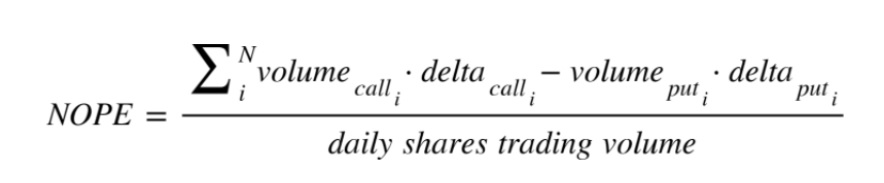

### Net Options Pricing Effect (NOPE)

In [15]:
NOPE = (sum((((data["call_volumes"]*contracts).mul(data["call_delta"]*contracts)).values-((data["put_volumes"]*contracts).mul(abs(data["put_delta"]*contracts))).values)))/und_volume
NOPE

0.0348338871604895

## ratio of underlying volume to options volume

In [16]:
result = np.nansum(data["stats_volume"])*contracts/und_volume
result

2.1966037221699826